Precision: 0.84
Recall: 0.84
F1 Score: 0.84


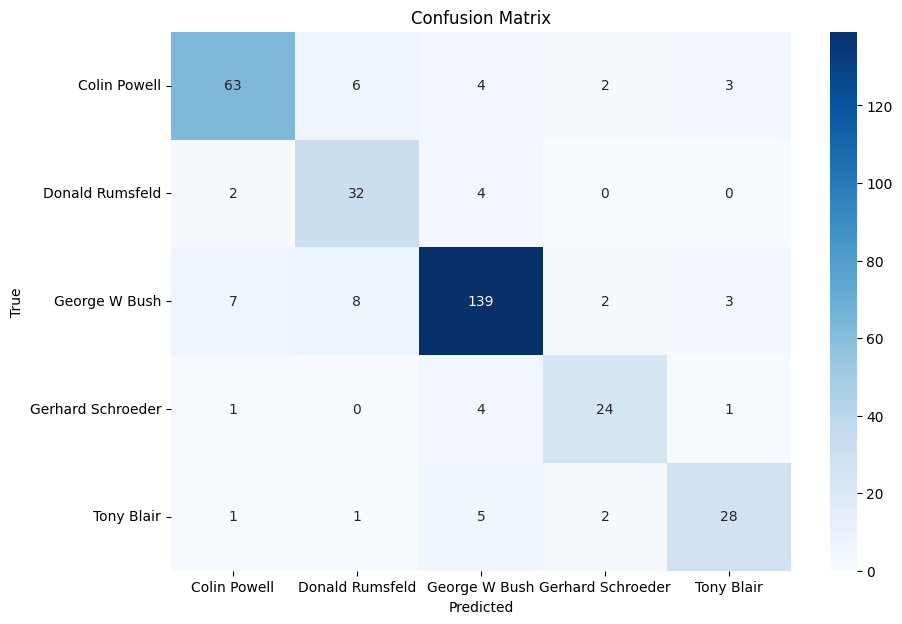

Capture your face for registration:
Press 'c' to capture your face and 'q' to quit.
Capture your face for verification:
Press 'c' to capture your face and 'q' to quit.
Predicted Label: 4
Face matched! Access granted.


In [3]:
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.svm import SVC

# Function to capture and preprocess a single face image
def capture_face():
    cap = cv2.VideoCapture(0, cv2.CAP_DSHOW)  # Use CAP_DSHOW to ensure compatibility on Windows
    if not cap.isOpened():
        print("Error: Could not open the camera. Please check your webcam or permissions.")
        return None

    print("Press 'c' to capture your face and 'q' to quit.")
    while True:
        ret, frame = cap.read()
        if not ret:
            print("Error: Failed to capture frame. Please check your webcam.")
            break
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        cv2.imshow('Capture Face', gray)
        if cv2.waitKey(1) & 0xFF == ord('c'):
            cap.release()
            cv2.destroyAllWindows()
            face = cv2.resize(gray, (50, 37))  # Resize to match dataset dimensions
            return face.flatten()  # Flatten the image
        elif cv2.waitKey(1) & 0xFF == ord('q'):
            cap.release()
            cv2.destroyAllWindows()
            return None

# Load the dataset (Labeled Faces in the Wild)
from sklearn.datasets import fetch_lfw_people

# Fetch the dataset
lfw_dataset = fetch_lfw_people(min_faces_per_person=100, resize=0.4)
images = lfw_dataset.images
labels = lfw_dataset.target

# Preprocessing
X = images.reshape(images.shape[0], -1)  # Flatten the images
y = labels

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Apply PCA (Eigenfaces) for dimensionality reduction
n_components = 150  # Number of eigenfaces to use
pca = PCA(n_components=n_components, whiten=True).fit(X_train)

X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

# Train an SVM classifier on the transformed data
svm = SVC(kernel='linear', class_weight='balanced')
svm.fit(X_train_pca, y_train)

# Evaluate the classifier on the test set
y_pred = svm.predict(X_test_pca)

# Calculate precision, recall, and f1 score
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plotting Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=lfw_dataset.target_names, yticklabels=lfw_dataset.target_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Simulate face unlock
print("Capture your face for registration:")
registered_face = capture_face()
if registered_face is None:
    print("Face registration aborted.")
else:
    print("Capture your face for verification:")
    verification_face = capture_face()
    if verification_face is None:
        print("Face verification aborted.")
    else:
        # Preprocess the verification face
        verification_face_pca = pca.transform([verification_face])

        # Predict the label for the verification face
        prediction = svm.predict(verification_face_pca)[0]
        print(f"Predicted Label: {prediction}")

        # Compare the prediction with the registered face
        registered_face_pca = pca.transform([registered_face])

        if prediction == svm.predict(registered_face_pca)[0]:
            print("Face matched! Access granted.")
        else:
            print("Face did not match! Access denied.")

# Dataset link (for reference):
# http://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_lfw_people.html